In [1]:
import sys, os
import math
sys.path.insert(1,os.path.abspath(os.path.join(os.getcwd(), '../../')))
import gillespy2
import matplotlib.pyplot as plt

In [2]:
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen
import tempfile
sbml_file = 'https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000028.2?filename=BIOMD0000000028_url.xml'
response = urlopen(sbml_file)
tmp = tempfile.NamedTemporaryFile(delete = False)
tmp.write(response.read())
tmp.close()
######

sbml_model, errors = gillespy2.import_SBML(tmp.name)
print(os.linesep.join([error for error, code in errors]))
print("-----")
os.remove(tmp.name)
######


-----


In [3]:
dresults = sbml_model.run(algorithm = "ODE")

#Convert results object to an array via method below
dresults = dresults.to_array()

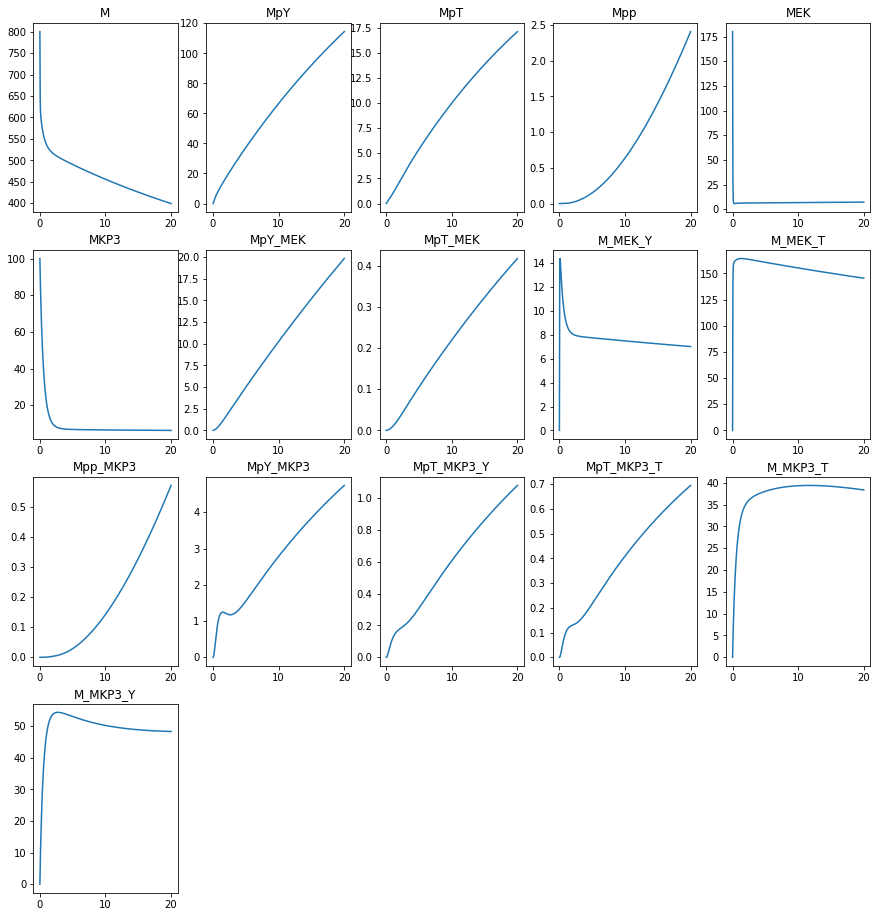

In [4]:
ns = len(sbml_model.listOfSpecies)
plt.figure(figsize=(15,4*int(math.ceil(ns/5.0))))
for n,s in enumerate(sbml_model.listOfSpecies):
    plt.subplot(int(math.ceil(ns/5.0)),5,n+1)
    plt.plot(dresults[0][:,0],dresults[0][:,n+1])
    plt.title(s)

In [5]:
sbml_model.name

'Markevich2004_MAPK_phosphoRandomElementary'

In [6]:
for r in sbml_model.listOfReactions:
    print("{0}\t{1}".format(r,sbml_model.listOfReactions[r].propensity_function))

reaction_0000001	(cell*(((k1*M)*MEK)-(k_1*M_MEK_Y)))
reaction_0000002	((cell*k2)*M_MEK_Y)
reaction_0000003	(cell*(((k3*MpY)*MEK)-(k_3*MpY_MEK)))
reaction_0000004	((cell*k4)*MpY_MEK)
reaction_0000005	(cell*(((k5*M)*MEK)-(k_5*M_MEK_T)))
reaction_0000006	((cell*k6)*M_MEK_T)
reaction_0000007	(cell*(((k7*MpT)*MEK)-(k_7*MpT_MEK)))
reaction_0000008	((cell*k8)*MpT_MEK)
reaction_0000009	(cell*(((h1*Mpp)*MKP3)-(h_1*Mpp_MKP3)))
reaction_0000010	((cell*h2)*Mpp_MKP3)
reaction_0000011	(cell*((h3*MpT_MKP3_Y)-((h_3*MpT)*MKP3)))
reaction_0000012	((cell*h5)*MpT_MKP3_T)
reaction_0000013	(cell*(((h4*MpT)*MKP3)-(h_4*MpT_MKP3_T)))
reaction_0000014	((cell*h8)*MpY_MKP3)
reaction_0000015	(cell*((h6*M_MKP3_T)-((h_6*M)*MKP3)))
reaction_0000017	(cell*(((h7*MpY)*MKP3)-(h_7*MpY_MKP3)))
reaction_0000019	(cell*((h9*M_MKP3_Y)-((h_9*M)*MKP3)))


In [7]:
new_rxns = []
for rname in sbml_model.listOfReactions:
    r = sbml_model.listOfReactions[rname]
    #print r.propensity_function
    rxns = r.propensity_function.replace('cell * ','').replace('(','').replace(')','').split('-')
    #print rxns, r.reactants, r.products
    r1 = gillespy2.Reaction(name=r.name,  reactants=r.reactants, 
                           products=r.products,
                           propensity_function = rxns[0])
    new_rxns.append(r1)
    if len(rxns) > 1:
        r2 = gillespy2.Reaction(name=r.name+'__reverse',  
                               reactants=r.products, 
                               products=r.reactants,
                               propensity_function = rxns[1])
    
        new_rxns.append(r2)

In [8]:
for s in sbml_model.listOfSpecies:
    print(s,sbml_model.listOfSpecies[s].initial_value)

M 800.0
MpY 0.0
MpT 0.0
Mpp 0.0
MEK 180.0
MKP3 100.0
MpY_MEK 0.0
MpT_MEK 0.0
M_MEK_Y 0.0
M_MEK_T 0.0
Mpp_MKP3 0.0
MpY_MKP3 0.0
MpT_MKP3_Y 0.0
MpT_MKP3_T 0.0
M_MKP3_T 0.0
M_MKP3_Y 0.0


In [9]:
r = sbml_model.listOfReactions['reaction_0000001']
print(r.propensity_function)
print(r.propensity_function.replace('(','').replace(')','').split())

(cell*(((k1*M)*MEK)-(k_1*M_MEK_Y)))
['cell*k1*M*MEK-k_1*M_MEK_Y']


In [10]:
'''If we assume the volume is 1.0, we can use the existing propensity 
functions when we convert to a stochastic model.'''
class Markevich2004_MAPK_phosphoRandomElementary(gillespy2.Model):
    def __init__(self, concentration_model):
        gillespy2.Model.__init__(self, name="Markevich2004_MAPK_phosphoRandomElementary")
        
        for s in concentration_model.listOfSpecies:
            self.add_species(gillespy2.Species(name=s, initial_value=int(concentration_model.listOfSpecies[s].initial_value)))
            
        for p in concentration_model.listOfParameters:
            self.add_parameter(concentration_model.listOfParameters[p])
            
        #for r in concentration_model.listOfReactions:
        #    self.add_reaction(concentration_model.listOfReactions[r])
        new_rxns = []
        for rname in concentration_model.listOfReactions:
            r = concentration_model.listOfReactions[rname]
            #print r.propensity_function
            rxns = r.propensity_function.replace('cell * ','').replace('(','').replace(')','').split('-')
            #print rxns, r.reactants, r.products
            r1 = gillespy2.Reaction(name=r.name,  reactants=r.reactants, 
                                   products=r.products,
                                   propensity_function = rxns[0])
            new_rxns.append(r1)
            if len(rxns) > 1:
                r2 = gillespy2.Reaction(name=r.name+'__reverse',  
                                       reactants=r.products, 
                                       products=r.reactants,
                                       propensity_function = rxns[1].lstrip())

                new_rxns.append(r2)
        self.add_reaction(new_rxns)

In [11]:
from gillespy2 import TauLeapingSolver
stoch_model = Markevich2004_MAPK_phosphoRandomElementary(sbml_model)
sresults = stoch_model.run(algorithm = "Tau-Leaping")

##Convert a results object to an array, via the method below
sresults = sresults.to_array()

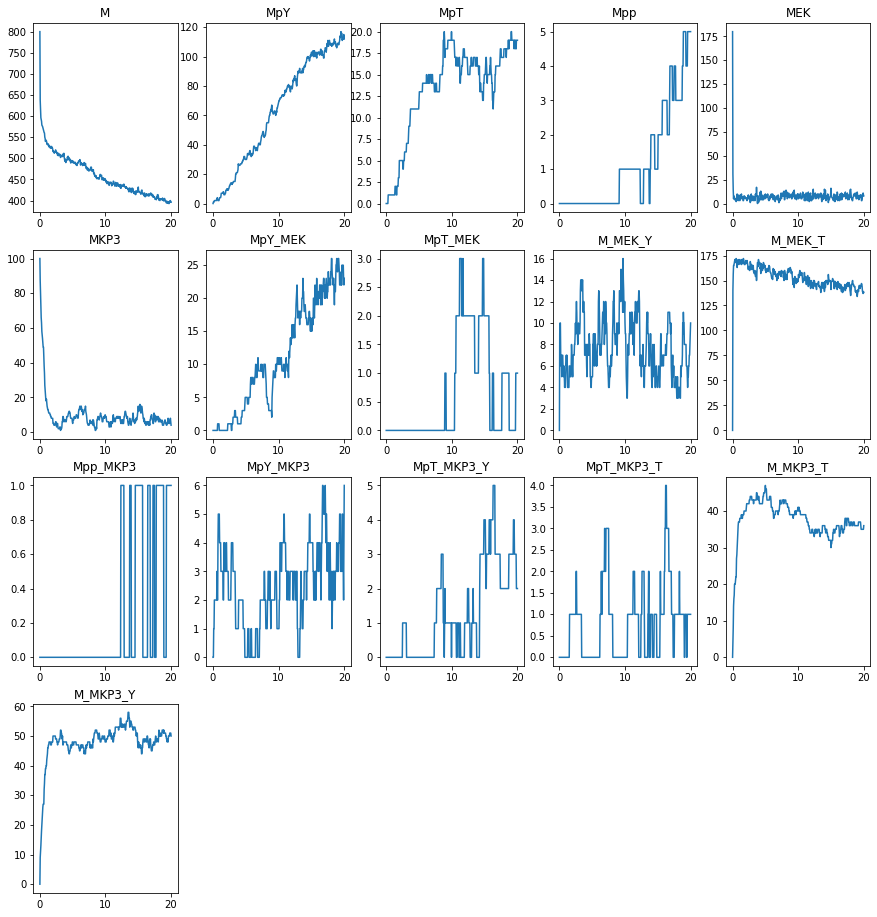

In [12]:
ns = len(stoch_model.listOfSpecies)
plt.figure(figsize=(15,4*int(math.ceil(ns/5.0))))
for n,s in enumerate(stoch_model.listOfSpecies):
    plt.subplot(int(math.ceil(ns/5.0)),5,n+1)
    plt.plot(sresults[0][:,0],sresults[0][:,n+1])
    plt.title(s)
